In [228]:
import numpy as np
import math
import pandas as pd
import pygplates
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [229]:
df = pd.read_excel('/Users/Andrew/Documents/PhD/Models/Palaeomag/Neoprot-poles.xlsx')

In [230]:
df

,colourkey,Key,Craton,Rockunit,OldAge,YoungAge,Slat,Slong,Plat,Plong,A95,Reference,Q-factor,Declination,Inclination
0,Laurentia,L1,Laurentia,Gunbarrel Intrusions combined,780,776,45.00,-110.00,14.6,127.0,3.2,"Harlan et al., 2008",1110111 (6),301.500000,-17.100000
1,Laurentia,L2,Laurentia,Uinta Formation,800,750,41.00,-110.00,0.8,161.3,4.7,"Weil et al., 2006",0110111 (5),190.222222,-4.966667
2,Laurentia,L3,Laurentia,Kwagunt Formation,748,736,36.15,-112.00,18.2,166.0,7.0,"Weil et al., 2004",1111111 (7),280.800000,30.600000
3,Laurentia,L4,Laurentia,Franklin Dykes,727,712,75.00,-82.00,8.4,163.8,2.8,"Denyszyn et al., 2009",1111111 (7),117.425000,68.333000
4,Laurentia,L5,Laurentia,Long Range Dykes,617,613,53.50,-57.50,-19.0,175.3,17.4,"Murthy et al., 1992; Hodych et al., 2004;Age: ...",1011111 (6),110.300000,56.800000
5,Laurentia,L6,Laurentia,Skinner Cove Formation,554,548,50.00,-60.00,15.0,157.0,9.0,"McCausland and Hodych, 1998",1111001 (5),144.000000,32.000000
6,Baltica,B1,Baltica,Southern Sweden Dykes,946,935,59.00,16.00,-0.9,240.7,6.7,"Elming et al., 2014; Pisarevsky and Bylund, 2006",1111111 (7),310.600000,-38.600000
7,Baltica,B2,Baltica,Branton-Algo Anortthosite,927,905,58.50,6.50,5.0,249.0,3.9,"Stearn and Piper, 1984; Age: Scherstén et al.,...",1110101 (5),300.400000,-23.800000
8,Baltica,B3,Baltica,Rogaland Igneous Complex,883,855,58.50,6.00,-46.0,238.0,18.1,"Walderhaug et al., 2007",1010101 (4),269.000000,-72.000000
9,Baltica,B4,Baltica,Hunnedalen Dykes,875,821,59.00,6.75,41.0,222.0,10.0,"Walderhaug et al., 1999",1110101 (5),294.000000,-75.000000


In [231]:
inclination = [] 
for i in df['Inclination']:    
    inclination.append(np.rad2deg(np.arctan(np.tan(np.deg2rad(i))/2)))

In [232]:
age_error = []
age_average = []
a95_error = []
colorkeys = []

for i,j in zip(df['OldAge'],df['YoungAge']):
    age_error.append((i+j)/2 - j)
    age_average.append((i+j)/2)

for k in df['A95']:
    a95_error.append(k/2)

for j in df['colourkey']:
    colorkeys.append(str(j))


In [233]:
unique_colorkeys = np.unique(colorkeys)
viridis = cm.get_cmap('viridis', len(unique_colorkeys))
print viridis.colors

[[0.267004 0.004874 0.329415 1.      ]
 [0.283072 0.130895 0.449241 1.      ]
 [0.262138 0.242286 0.520837 1.      ]
 [0.220057 0.343307 0.549413 1.      ]
 [0.177423 0.437527 0.557565 1.      ]
 [0.143343 0.522773 0.556295 1.      ]
 [0.119512 0.607464 0.540218 1.      ]
 [0.166383 0.690856 0.496502 1.      ]
 [0.319809 0.770914 0.411152 1.      ]
 [0.525776 0.833491 0.288127 1.      ]
 [0.762373 0.876424 0.137064 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


In [246]:
unique_colorkeys = np.unique(colorkeys)

In [247]:
color_dict = dict(zip(unique_colorkeys, viridis.colors))

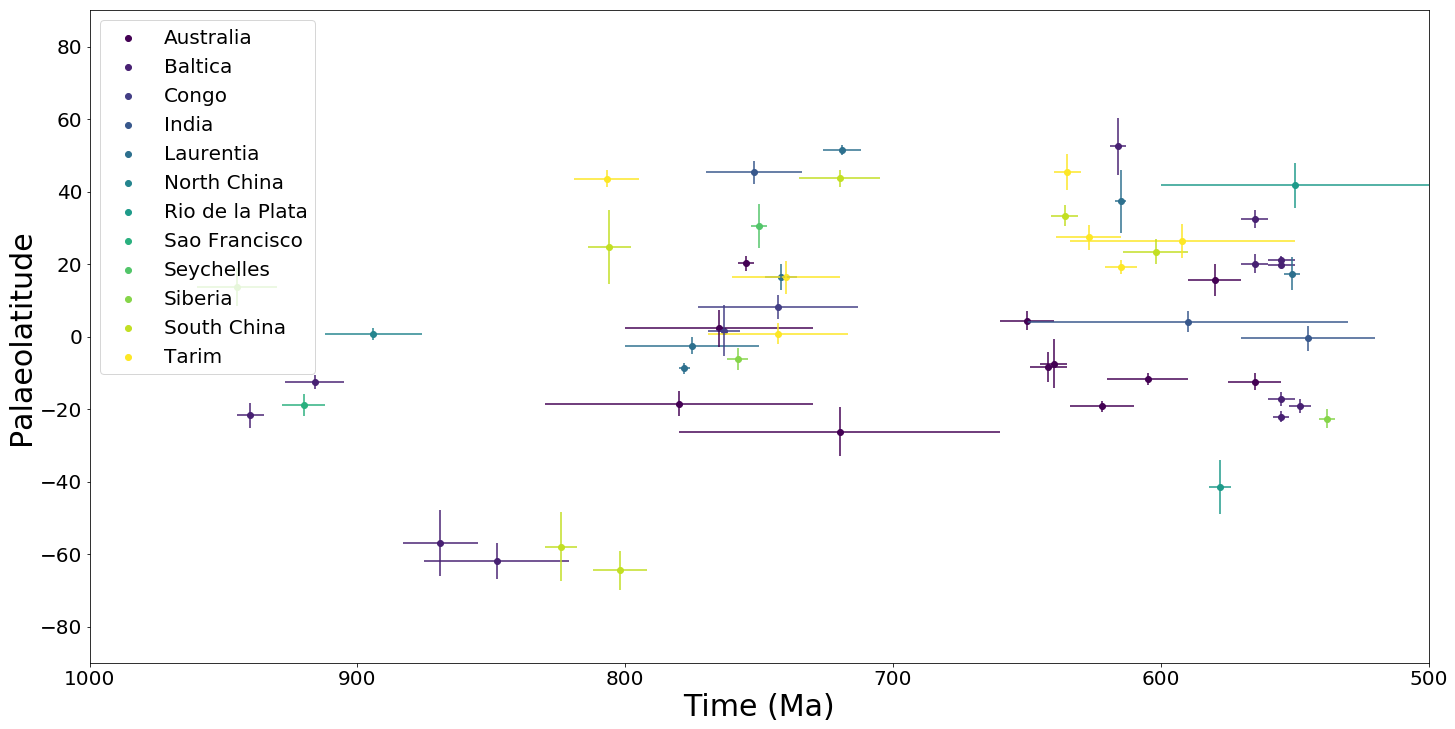

In [262]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,12))

for i, u in enumerate(unique_colorkeys):
    xi = [age_average[j] for j  in range(len(age_average)) if colorkeys[j] == u]
    yi = [inclination[j] for j  in range(len(age_average)) if colorkeys[j] == u]
    ax.scatter(xi, yi, c=colors[i], label=str(u))

ax.errorbar(age_average, inclination, yerr=a95_error, xerr=age_error, color=[color_dict[i] for i in colorkeys], ls='none')
ax.legend(loc='upper left', fontsize=20)
ax.set_xlim(1000,500)
ax.set_ylim(-90,90)
ax.set_xlabel('Time (Ma)', fontsize=30)
ax.set_ylabel('Palaeolatitude', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('/Users/Andrew/Documents/PhD/Manuscripts/Presentations/1_ga_model/palaeolatitude.pdf')